In [1]:
# import dash, math, datetime as dt, 
# from dash.dependencies import Input, Output, State, ClientsideFunction
# from dash import dcc, html
# import dash_bootstrap_components as dbc
# from dash_bootstrap_templates import load_figure_template
import pandas as pd
import plotly
import plotly.io as pio
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px
import datetime    
import utils
from tqdm import tqdm 
tqdm.pandas()
import spacy
nlp = spacy.load('pt_core_news_sm')

%load_ext autoreload
%autoreload 2
import figures, main_etl, extract_data, transform_data

# Seaborn colors  
# ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', 
# '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']    

In [14]:
from github import Github
from zenhub import Zenhub

with open('tokens.txt') as f:
     git_token, zh_token = [line.rstrip('\n') for line in f.readlines()]    
        
zh = Zenhub(zh_token)
g = Github(git_token)

repo_id='357557193'    
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

## Update Dados Coleta

In [7]:
%%time 

main_etl.update_data_coletas(git_token, zh_token) # 8min 33s
# main_etl.update_data_desenvolvimento(git_token, zh_token)

Limite de requisicoes alcancado (ZenHub). Aguardando um minuto..
Limite de requisicoes alcancado (ZenHub). Aguardando um minuto..
CPU times: user 43.2 s, sys: 575 ms, total: 43.7 s
Wall time: 11min 33s


## Clusterização de portais

### Diferenças entre fontes

In [110]:
planilha = pd.read_csv('data/Portais x Templates - links_validados.csv', 
                       usecols=['#Rank', 'Município','Desenvolvedor', 
                                'Portal da Transparência (validado)']
                      ).sort_values('#Rank')
print('Planilha:', planilha.shape)
display(planilha.head())

clustering = pd.read_csv('data/municipios_clusters.csv',
                        usecols=['municipio', 'template_name_size',
                                 'template', 'cluster_id'])
print('Clustering:', clustering.shape)
display(clustering.head())

Planilha: (853, 4)


,#Rank,Município,Desenvolvedor,Portal da Transparência (validado)
65,1,Belo Horizonte,prefeitura,https://transparencia.pbh.gov.br/
824,2,Uberlândia,prefeitura,https://www.uberlandia.mg.gov.br/portal-da-tra...
205,3,Contagem,prefeitura,http://www.contagem.mg.gov.br/transparencia/
418,4,Juiz de Fora,prefeitura,https://www.pjf.mg.gov.br/transparencia/
71,5,Betim,prefeitura,http://www.betim.mg.gov.br/transparencia/


Clustering: (837, 4)


,municipio,template_name_size,template,cluster_id
0,Alvorada de Minas,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
1,Aricanduva,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
2,Augusto de Lima,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
3,Berilo,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
4,Bocaiúva,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5


In [111]:
# pre-processing
clustering.template = clustering.template.str.normalize('NFKD').str.encode(
    'ascii', errors='ignore').str.decode('utf-8')
clustering.template = clustering.template.str.lower()
clustering.template = clustering.template.str.replace(' ', '')
planilha.Desenvolvedor = planilha.Desenvolvedor.str.lower()
planilha.Desenvolvedor = planilha.Desenvolvedor.str.replace(' ', '')
clustering.template = clustering.template.fillna('sem_nome_no_clustering')

clustering.loc[clustering.municipio == 'Pingo d\'Água', 'municipio'] = 'Pingo-d\'Água'
clustering.loc[clustering.municipio == 'São Thomé das Letras', 'municipio'] = 'São Tomé das Letras'

# merge
merged = pd.merge(planilha, clustering, left_on='Município', right_on='municipio', how='outer')
merged

,#Rank,Município,Desenvolvedor,Portal da Transparência (validado),municipio,template_name_size,template,cluster_id
0,1,Belo Horizonte,prefeitura,https://transparencia.pbh.gov.br/,Belo Horizonte,Template1 (9),template1,24.0
1,2,Uberlândia,prefeitura,https://www.uberlandia.mg.gov.br/portal-da-tra...,Uberlândia,NaN,sem_nome_no_clustering,403.0
2,3,Contagem,prefeitura,http://www.contagem.mg.gov.br/transparencia/,Contagem,NaN,sem_nome_no_clustering,772.0
3,4,Juiz de Fora,prefeitura,https://www.pjf.mg.gov.br/transparencia/,Juiz de Fora,NaN,sem_nome_no_clustering,63.0
4,5,Betim,prefeitura,http://www.betim.mg.gov.br/transparencia/,Betim,NaN,sem_nome_no_clustering,651.0
...,...,...,...,...,...,...,...,...
848,849,São Sebastião do Rio Preto,prefeitura,http://saosebastiaodoriopreto.mg.gov.br/transp...,São Sebastião do Rio Preto,NaN,sem_nome_no_clustering,66.0
849,850,Senador José Bento,portalfacil,http://www.transparenciafacil.com.br/0211202,Senador José Bento,Portal Fácil (46),portalfacil,2.0
850,851,Grupiara,404,http://179.189.0.196:8444/transparencia/,NaN,NaN,NaN,NaN
851,852,Cedro do Abaeté,adpm,http://www.adpmnet.com.br/index.php?option=com...,Cedro do Abaeté,ADPM (22),adpm,28.0


In [115]:
conflicts = merged[merged.Desenvolvedor != merged.template]
conflicts = conflicts[['#Rank', 'Município', 'municipio', 'Desenvolvedor', 'template', 'template_name_size', 
                       'cluster_id', 'Portal da Transparência (validado)']]
conflicts = conflicts.rename(columns={'Município': 'Municipio (Planilha)',
                                      'municipio': 'Municipio (Clustering)',
                                      'Desenvolvedor': 'Desenvolvedor (Planilha)',
                                      'template': 'Template (Clustering)'}) 
conflicts = conflicts.sort_values(['Desenvolvedor (Planilha)', 'Municipio (Planilha)'])                                      
conflicts.to_csv('data/conflitos_templates.csv', index=False)
conflicts

,#Rank,Municipio (Planilha),Municipio (Clustering),Desenvolvedor (Planilha),Template (Clustering),template_name_size,cluster_id,Portal da Transparência (validado)
357,358,Delta,Delta,3gdelta,sem_nome_no_clustering,NaN,29.0,http://www.delta.mg.gov.br/portal-da-transpare...
372,373,Itamogi,Itamogi,3gnet,sem_nome_no_clustering,NaN,162.0,https://itamogi.mg.gov.br/transparencia/
457,458,Limeira do Oeste,Limeira do Oeste,3gnet,sem_nome_no_clustering,NaN,470.0,https://limeiradooeste.mg.gov.br/portal-da-tra...
404,405,Monsenhor Paulo,Monsenhor Paulo,3gnet,sem_nome_no_clustering,NaN,492.0,https://camaramonsenhorpaulo.mg.gov.br/portal-...
596,597,Senador Amaral,Senador Amaral,3gnet,sem_nome_no_clustering,NaN,563.0,https://senadoramaral.mg.gov.br/portal-da-tran...
...,...,...,...,...,...,...,...,...
227,228,Tocantins,Tocantins,wms,sem_nome_no_clustering,NaN,30.0,https://tocantins.mg.gov.br/transparencia/
89,90,Boa Esperança,Boa Esperança,NaN,betha,Betha (7),64.0,https://e-gov.betha.com.br/transparencia/01037...
164,165,Carmo do Cajuru,Carmo do Cajuru,NaN,betha,Betha (7),64.0,https://e-gov.betha.com.br/transparencia/01037...
172,173,Monte Alegre de Minas,NaN,NaN,NaN,NaN,NaN,http://187.72.215.252:8080/dadosweb/loginWeb.j...


,#Rank,Município,Desenvolvedor,Portal da Transparência (validado),municipio,template_name_size,template,cluster_id
11,12.0,Divinópolis,grp,http://177.69.246.151:8090/portalcidadao/#efb3...,NaN,NaN,NaN,NaN
147,148.0,São João da Ponte,colorlib,https://saojoaodaponte.mg.gov.br/transparencia,NaN,NaN,NaN,NaN
172,173.0,Monte Alegre de Minas,NaN,http://187.72.215.252:8080/dadosweb/loginWeb.j...,NaN,NaN,NaN,NaN
211,212.0,Lagoa Formosa,404,http://transparencia.lagoaformosa.mg.gov.br:84...,NaN,NaN,NaN,NaN
217,218.0,Bom Sucesso,memory,http://lai.memory.com.br/entidades/login/98CSD1,NaN,NaN,NaN,NaN
274,275.0,Ibiraci,portal facil,http://ibiraci.mg.gov.br/portal-da-transparencia/,NaN,NaN,NaN,NaN
351,352.0,Miradouro,404,https://prefeitura24horas.online/_transparenci...,NaN,NaN,NaN,NaN
481,482.0,São Tomé das Letras,fiorilli,https://portal.sgpcloud.net:9016/transparencia/,NaN,NaN,NaN,NaN
490,491.0,Iraí de Minas,404,http://177.85.2.36:8444/transparencia/,NaN,NaN,NaN,NaN
515,516.0,Dona Euzébia,404,https://prefeitura24horas.online/_transparenci...,NaN,NaN,NaN,NaN


In [58]:
import json

with open('data/clusters.d3.json', 'r') as f:
     clusters_json = json.loads(f.read())

In [59]:
clusters_json['children'][:2]

[{'size': 10.0,
  'children': [{'size': 10.0, 'name': '146', 'index': 146}],
  'name': '146',
  'index': 146},
 {'size': 20.0,
  'children': [{'size': 10.0, 'name': '476', 'index': 476},
   {'size': 10.0, 'name': '227', 'index': 227}],
  'name': '227',
  'index': 227}]

In [73]:
clusters.dtypes

cluster_id      object
cluster_size     int64
municipio_id    object
dtype: object

In [88]:
import numpy as np
clusters = []

for cluster in clusters_json['children']:
    for municipio in cluster['children']:
        new_row = [int(cluster['name']), int(cluster['size']/10), int(municipio['name'])]
        clusters.append(new_row) 
        
clusters = pd.DataFrame(clusters, columns=['cluster_id', 'cluster_size', 'municipio_id'])
clusters

,cluster_id,cluster_size,municipio_id
0,146,1,146
1,227,2,476
2,227,2,227
3,92,1,92
4,514,1,514
...,...,...,...
832,0,11,481
833,0,11,359
834,0,11,384
835,0,11,457


In [65]:
municipios = pd.read_csv('data/part-00000', names=['municipio_id', 'html'])
municipios['nome'] = municipios['html'].apply(lambda x: x.split('/')[-1][:-5])

municipios

,municipio_id,html,nome
0,0,/home/pedro/MPMG/html_saver/Conceição do Rio V...,Conceição do Rio Verde
1,1,/home/pedro/MPMG/html_saver/Rio Novo.html,Rio Novo
2,2,/home/pedro/MPMG/html_saver/Cachoeira de Minas...,Cachoeira de Minas
3,3,/home/pedro/MPMG/html_saver/Rio Casca.html,Rio Casca
4,4,/home/pedro/MPMG/html_saver/Periquito.html,Periquito
...,...,...,...
832,832,/home/pedro/MPMG/html_saver/Monte Santo de Min...,Monte Santo de Minas
833,833,/home/pedro/MPMG/html_saver/Prados.html,Prados
834,834,/home/pedro/MPMG/html_saver/Buritizeiro.html,Buritizeiro
835,835,/home/pedro/MPMG/html_saver/Formoso.html,Formoso


In [69]:
cluster_template = pd.read_csv('data/cluster-template.csv')
cluster_template['name_size'] = cluster_template.template + ' (' + cluster_template['n_portais'].astype(str) + ')' 
cluster_template.head()

,rank,cluster_id,template,n_portais,name_size
0,1,5,Síntese Tecnologia e Informática,88,Síntese Tecnologia e Informática (88)
1,2,7,Memory,66,Memory (66)
2,3,1,Siplanweb,61,Siplanweb (61)
3,4,17,Portaltp,61,Portaltp (61)
4,5,6,Portal Fácil,60,Portal Fácil (60)


In [121]:
import json

def build_municipios_clusters_df(clusters_json_path, part_0000_path, cluster_template_path):
    with open(clusters_json_path, 'r') as f:
         clusters_json = json.loads(f.read())

    municipios = []
    for cluster in clusters_json['children']:
        for municipio in cluster['children']:
            new_row = [int(municipio['name']), int(cluster['name']), int(cluster['size']/10)]
            municipios.append(new_row) 
            
    municipios = pd.DataFrame(municipios, columns=['municipio_id', 'cluster_id', 'cluster_size'],
                            dtype=int)

    nomes_municipios = pd.read_csv(part_0000_path, names=['municipio_id', 'municipio'])
    nomes_municipios['municipio'] = nomes_municipios['municipio'].apply(lambda x: x.split('/')[-1][:-5])        
    municipios = municipios.merge(nomes_municipios, on='municipio_id', how='left')

    cluster_template = pd.read_csv(cluster_template_path)
    cluster_template['template_name_size'] = cluster_template.template + \
        ' (' + cluster_template.cluster_n_portais.astype(str) + ')' 
    municipios = municipios.merge(cluster_template, on='cluster_id', how='left')
    
    municipios = municipios.sort_values(['cluster_size', 'template', 'municipio'], 
                                        ascending=[False, True, True])
    municipios = municipios[['municipio_id', 'municipio', 'template', 
                             'cluster_id',	'cluster_size',	'cluster_rank',
                             'cluster_n_portais', 'template_name_size']]
    
    return municipios

#------------------------------------------

municipios = build_municipios_clusters_df('data/clusters.d3.json', 'data/part-00000', 'data/cluster-template.csv')
municipios.to_csv('data/municipios_clusters.csv', index=False)
municipios

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size
240,176,Alvorada de Minas,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
247,759,Aricanduva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
259,726,Augusto de Lima,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
270,666,Berilo,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
201,148,Bocaiúva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
...,...,...,...,...,...,...,...,...
26,403,Uberlândia,NaN,403,1,NaN,NaN,NaN
137,47,Varjão de Minas,NaN,47,1,NaN,NaN,NaN
614,141,Vazante,NaN,141,1,NaN,NaN,NaN
301,809,Verdelândia,NaN,809,1,NaN,NaN,NaN


In [120]:
municipios[(municipios.cluster_size != municipios.cluster_n_portais) 
           & (municipios.cluster_n_portais.notna())]

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size


In [124]:
municipios[municipios.template == 'Betha']['municipio'].values

,municipio_id,municipio,template_name_size,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais
703,98,Alterosa,Betha (26),Betha,3,26,10.0,26.0
720,364,Alto Rio Doce,Betha (26),Betha,3,26,10.0,26.0
698,81,Bandeira do Sul,Betha (26),Betha,3,26,10.0,26.0
704,607,Botelhos,Betha (26),Betha,3,26,10.0,26.0
709,158,Campos Gerais,Betha (26),Betha,3,26,10.0,26.0
699,597,Cataguases,Betha (26),Betha,3,26,10.0,26.0
719,23,Cláudio,Betha (26),Betha,3,26,10.0,26.0
695,233,Congonhas,Betha (26),Betha,3,26,10.0,26.0
696,625,Formiga,Betha (26),Betha,3,26,10.0,26.0
712,347,Ijaci,Betha (26),Betha,3,26,10.0,26.0


## Gráficos Semanais

In [188]:
df = pd.read_csv("data/df.csv")
week_status = count_by_week(df, time_column='closed_at')
week_status.head(15)

,week_year,closed_at,week,year
0,1/2022,56.0,1,2022
1,2/2022,70.0,2,2022
2,3/2022,63.0,3,2022
3,4/2022,55.0,4,2022
4,5/2022,5.0,5,2022
5,6/2022,91.0,6,2022
6,7/2022,65.0,7,2022
7,8/2022,188.0,8,2022
8,9/2022,124.0,9,2022
9,10/2022,232.0,10,2022


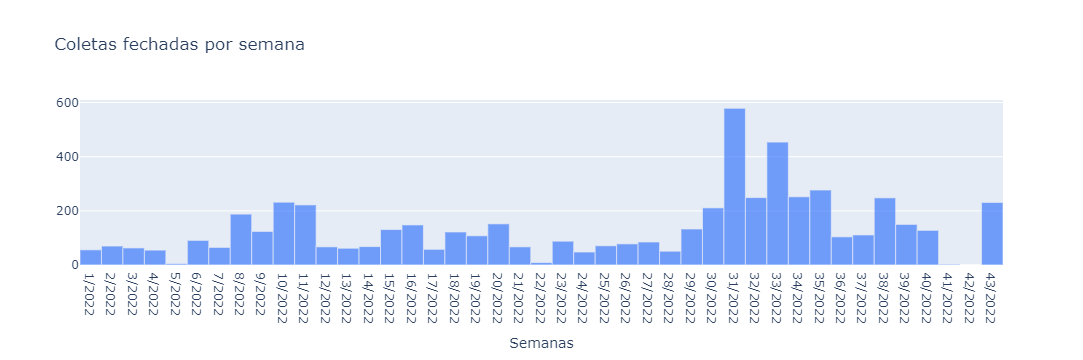

In [224]:
week_status = pd.read_csv('data/week_status.csv')    

figures.plot_status_week(week_status, title='Coletas fechadas por semana',
    y_column='closed_at', x_column='week_year',
    xaxis_title_text='Semanas') 

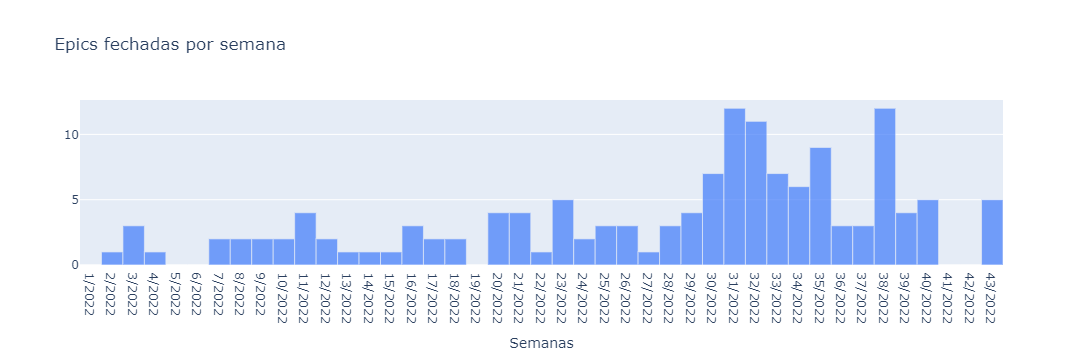

In [225]:
#TODO pq 8 ao inves de 10
count_epics_week = pd.read_csv("data/count_epics_week.csv")

figures.plot_status_week(
    count_epics_week, title='Epics fechadas por semana',
    y_column='Coletado', x_column='week_year', xaxis_title_text='Semanas')

## Gráfico com Previsões

,month_year,Coletado,Não coletável,closed,month,year
3,2/2022,4.0,0.0,4.0,2,2022
4,3/2022,11.0,0.0,11.0,3,2022
5,4/2022,7.0,12.0,19.0,4,2022
6,5/2022,10.0,3.0,13.0,5,2022
7,6/2022,14.0,4.0,18.0,6,2022
8,7/2022,15.0,15.0,30.0,7,2022
9,8/2022,46.0,10.0,56.0,8,2022
10,9/2022,24.0,12.0,36.0,9,2022
11,10/2022,12.0,1.0,13.0,10,2022
12,11/2022,10.0,1.0,11.0,11,2022


Coletado no ultimo mes   : 12.0
Coletado no penultimo mes: 10.0


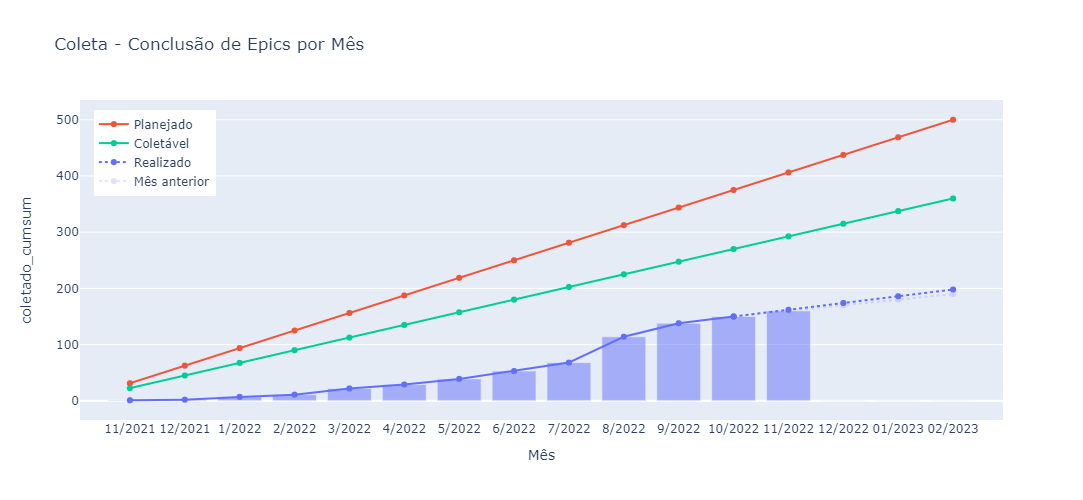

In [22]:
def plot_speed_epics(df, df_week, title):      
    
    df['coletado_cumsum'] = df['Coletado'].cumsum()   
    coletado_cumsum_anterior = df['coletado_cumsum'][:-1].values.tolist()
    # df["closed_cumsum"] = df["closed"].cumsum()             
    # df["naocoletado_cumsum"] = df["Não coletável"].cumsum()  
    
    total_coletado_mes_anterior  = df['Coletado'][:-1].sum()
    coletado_por_mes_atualizado = df_week['Coletado'][-4:].sum()  
    coletado_por_mes_anterior   = df_week['Coletado'][-8:-4].sum() # df['Coletado'][-2:-1].values[0]
    print(f'Coletado no ultimo mes   : {coletado_por_mes_atualizado}')
    print(f'Coletado no penultimo mes: {coletado_por_mes_anterior}')
    # fechado_por_mes = df["closed"].mean()      
    # total_coletado  = df['Coletado'].sum()

    # Definindo os meses de interesse
    df = df.merge( pd.DataFrame(["11/2021", "12/2021"] + [f'{x}/2022' for x in range(1,13)] + 
                                ["01/2023", "02/2023"], columns=["month_year"]), how="right").fillna(0)    
    
    # Baselines
    n_templates = 15 + 5            # 15 + 5 municipios
    total_epics_by_template = 25    # estimativas baseada em 13 templates    
    media_nao_coletavel = 7         
    
    total_epics = total_epics_by_template * n_templates    
    total_months = df.shape[0]
    future_months = total_months - len(coletado_cumsum_anterior) + 1
    ideal_speed = total_epics / total_months
    
    total_coletaveis = total_epics - (media_nao_coletavel * n_templates)
    ideal_speed_discounted = total_coletaveis / total_months
    
    previsao_mes_anterior = [total_coletado_mes_anterior + (i * coletado_por_mes_anterior) for i in range(future_months)]
    previsao_atual = [total_coletado_mes_anterior + (i * coletado_por_mes_atualizado) for i in range(future_months)]
    
    # Plot
    fig =  px.bar(df, x="month_year", y='coletado_cumsum', title=title, opacity=0.5, height=500, width=1000,
                 labels={"value":"Epics concluídas (acumulado)", "month_year":"Mês", 'variable':''})

    fig.update_layout(
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 100),
        legend = dict(x = 0.015, y = 0.97),
    )
    fig.add_traces([
        go.Scatter(x=df.month_year, y=[i * ideal_speed for i in range(1, total_months+1)], name="Planejado", opacity=1,
                  line=go.scatter.Line(color='#ef553b')), #color="red" ff6692 ef553b     
        go.Scatter(x=df.month_year, y=[i * ideal_speed_discounted for i in range(1, total_months+1)], name="Coletável",
                  line=go.scatter.Line(color="#00CC96")), #AB63FA
        go.Scatter(x=df.month_year, y=coletado_cumsum_anterior, name="Realizado", 
                  line=go.scatter.Line(dash='solid', color="#636efa"), opacity=1, showlegend=False), 
        go.Scatter(x=df.month_year[-future_months:], y=previsao_atual, name="Realizado", 
                  line=go.scatter.Line(dash='dot', color="#636efa"), opacity=1),
        go.Scatter(x=df.month_year[-future_months:], y=previsao_mes_anterior, name="Mês anterior",
                  line=go.scatter.Line(dash='dot', color="#636efa"), opacity=0.2),
        # go.Scatter(x=df.month_year, y=[i * velocidade_coleta for i in range(1, total_months+1)], name="Realizado",
        #           line=go.scatter.Line(color="#636efa"), opacity=1),#, text=df), #8c86ff
        # go.Scatter(x=df.month_year, y=mes_anterior, name="Mês anterior",
        #           line=go.scatter.Line(color="#636efa"), opacity=0.2),
        # go.Scatter(x=df.month_year, y=[i * velocidade_total for i in range(1, total_months+1)], name="Total Fechado",
        #           line=go.scatter.Line(color="blue"), opacity=0.1),    # Inclui todas epics fechadas
                    # dash -> ['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']
    ])
    
    return fig

#-------------------------------------------------------------------------------------
#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', 
# '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd'

count_epics_month = pd.read_csv("data/count_epics_month.csv")
count_epics_week  = pd.read_csv("data/count_epics_week.csv")
display(count_epics_month.tail(10))

# count_epics_month = count_epics_month[count_epics_month.month_year != '11/2022'] #TODO 
plot_speed_epics(count_epics_month, count_epics_week, title='Coleta - Conclusão de Epics por Mês') 


In [ ]:
repo = repo_F01
epics_id = [1928, 1645, 1935, 1330, 1964, 1963, 1905]

epics_info, count_epics_month, count_epics_week = transform_data.summarize_epics(epics_id, repo_F01)
count_epics_month, count_epics_week

## Gráfico de Visão Geral

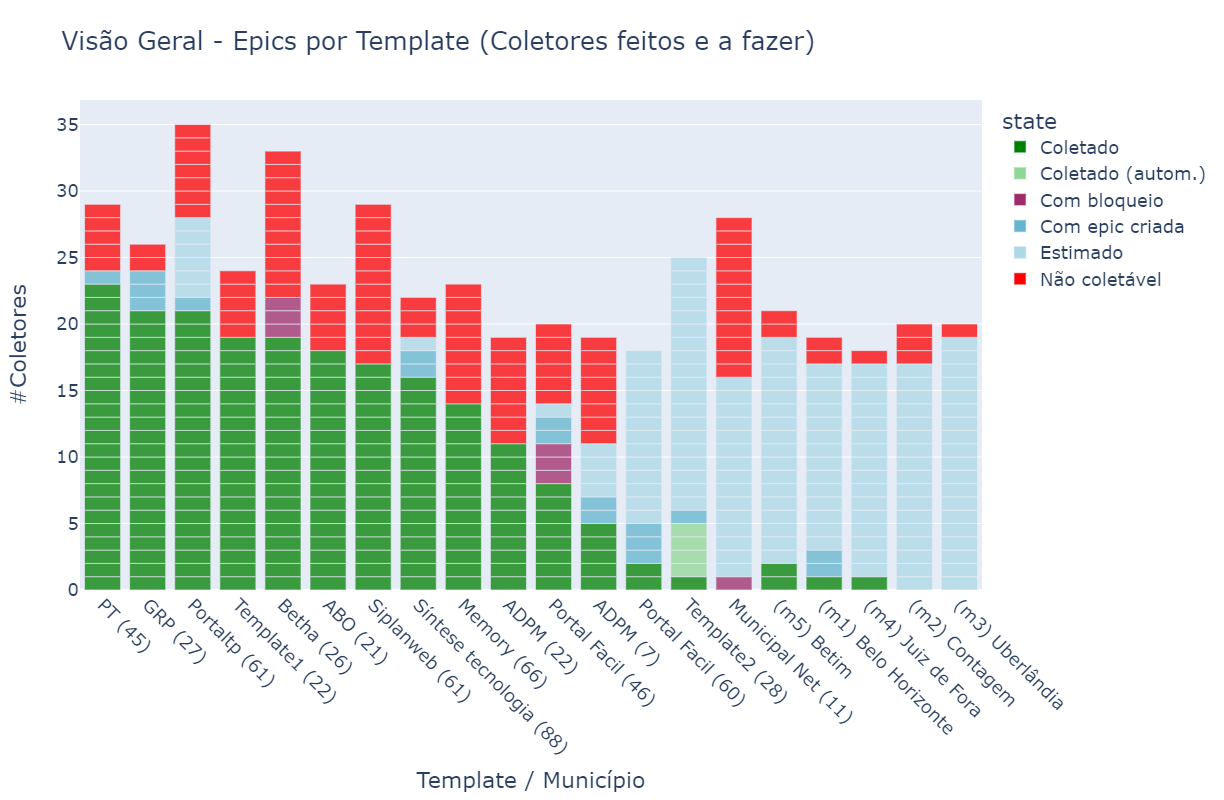

In [144]:
def plot_status_epics(df, top_templates, sondagem, title='Visão Geral - Epics por Template (Coletores feitos e a fazer)'):
    from math import isnan

    top_templates = top_templates[top_templates['rank'] <= 15]
    stats = top_templates.set_index('template').to_dict()
    total = stats['total_epics']
    
    # total nao coletavel (analise manual)
    total_nc = stats['total_nao_coletavel']
    total_nc = {a: int(b) for a,b in total_nc.items() if not isnan(b) }

    for template, count in total_nc.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável', 'aux':1}, ignore_index=True)
                
    # resultados de coletas e analises automaticas 
    coletado_autom = {'Template2 (28)': 4}
    nao_loc_autom  = {}
    for template, count in nao_loc_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável (autom.)', 'aux':1}, ignore_index=True)
    for template, count in coletado_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Coletado (autom.)', 'aux':1}, ignore_index=True)
       
    # Pre-processing data
    count_col = 'aux'
    name_col  = 'shortname'
    df = top_templates.merge(df, how='left').fillna({'state':'Estimado', count_col:1})   
    templates = df['template'].dropna().unique()     
   
    # Fill missing (estimated) epics in df
    for template in templates:        
        created =  df.groupby('template').count()['state'][template]
        missing = total[template] - created
        size = df[df.template == template]['size'].values[0]
        name = df[df.template == template][name_col].values[0]

        for i in range(missing):            
            df = df.append({'template':template, 'state':'Estimado', name_col:name,
                            'size':size, count_col:1}, ignore_index=True)           

    # sorting x-axis
    df = df.sort_values(by=['state', name_col], ascending=[True,True])
    xorder = df.groupby(['state', name_col]).count()['aux']['Coletado']
    for x in df[name_col].unique():
        if x not in xorder: xorder[x] = 0
        
    xorder = xorder.sort_values(ascending=False).index.tolist()
    m = [x for x in xorder if x.startswith('(m')]
    xorder = [x for x in xorder if x not in m]
    xorder = xorder + m
    
    # Plot
    fig = px.bar(
        df, y=count_col, x=name_col, color='state', height=800, width=1100, title=title,
        color_discrete_map = { 'Coletado':'green', 'Coletado (autom.)':'#92d696', 
            'Com bloqueio':'#9F2B68', 'Com epic criada':'#64b5cd', 'Estimado':'lightblue', 
            'Não coletável':'red', 'Não coletável (autom.)':'#ff9e99'}, 
        labels = {count_col:"#Coletores", name_col:"Template / Município"}, 
        opacity = 0.75 )    
    
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':xorder}, font=dict(size=18))
    fig.update_xaxes(tickangle=45)
    
    return fig

#-------------------------------------------------------------

epics_df = pd.read_csv("data/epics.csv")
top_templates = pd.read_csv("data/top_templates.csv", 
                            dtype={'total_epics':int})
sondagem = pd.read_csv('data/resultados_templates.csv', index_col=0).astype(int)

fig = plot_status_epics(epics_df, top_templates, sondagem)    
fig.write_image('./fig/status-coleta.png', scale=1)
fig

In [133]:
df = d.copy()
name_col  = 'shortname'
    
df = df.sort_values(by=['state', name_col], ascending=[True,True])
remaining = df.groupby(['state', name_col]).count()['aux']['Estimado']

shortnames = df.shortname.unique()
for s in shortnames:
    if s not in remaining:
        remaining[s] = 0

remaining.sort_values(ascending=True)#.index.tolist()


shortname
Template1 (22)              0
PT (45)                     0
Memory (66)                 0
GRP (27)                    0
Betha (26)                  0
ADPM (22)                   0
ABO (21)                    0
Siplanweb (61)              0
Portal Facil (46)           1
Síntese tecnologia (88)     1
ADPM (7)                    4
Portaltp (61)               6
Portal Facil (60)          13
(m1) Belo Horizonte        14
Municipal Net (11)         15
(m4) Juiz de Fora          16
(m5) Betim                 17
(m2) Contagem              17
(m3) Uberlândia            19
Template2 (28)             19
Name: aux, dtype: int64

In [128]:
templates = df['template'].dropna().unique()  
templates

array(['Belo Horizonte', 'Juiz de Fora', 'Betim', 'ABO (21)', 'ADPM (22)',
       'ADPM (7)', 'Betha (26)', 'GRP (27)', 'Memory (66)', 'PT (45)',
       'Portal Facil (46)', 'Portal Facil (60)', 'Portaltp (61)',
       'Siplanweb (61)', 'Síntese tecnologia e informatica (88)',
       'Template1 (22)', 'Template2 (28)', 'Municipal Net (11)',
       'Contagem', 'Uberlândia'], dtype=object)

In [43]:
# already copied
def expand_states(df, target_labels=['template', 'tag', 'subtag', 'município'], remove_orig_col=True):
    
    for target_label in target_labels:
        df[target_label] = df.apply(lambda x: find_label(x['labels'], target_label), axis=1)
    
    # Utiliza nome do município na coluna template
    df.template = df.template.fillna(df['município'])
    df = df.drop(columns='município')
    
    #NOTE todas epics com label 'não-*' estão sendo agrupadas como 'Não coletável'
    df.loc[df.labels.astype(str).str.contains('não-'), 'state'] = 'Não coletável'   
    
    df.loc[df.labels.astype(str).str.contains('bloqueada'), 'state'] = 'Com bloqueio'    
    df.loc[df.state == 'closed', 'state'] = 'Coletado'
    df.loc[df.state == 'open', 'state'] = 'Com epic criada'
    
    df = df.rename(columns={'number':'git_issue'})
    df['aux'] = 1
    
    if remove_orig_col:
        df = df.drop(columns='labels')
    
    return df

find_label = transform_data.find_label

e = [1331, 2365, 2417, 2415, 2416, 93, 324, 2434] # why not loaded
# e = extract_data.get_epics_ids(zh, repo_id)[:20]
print(e)

epics = extract_data.get_issues_by_number(repo_F01, numbers=e)
epics = pd.DataFrame(extract_data.add_issues_info([epics]))   
epics = epics.loc[epics['title'].str.find("Coletor para") != -1]
expand_states(epics)


[1331, 2365, 2417, 2415, 2416, 93, 324, 2434]


,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
1,Coletor para o template Portal Fácil (46) - De...,2365,2022-12-12 11:34:31,NaT,Com epic criada,Portal Facil (46),Despesas,"[Empenhos, Consulta, Gerar relatório]",1
2,Coletor para o município de Betim - Contratos,2417,2023-01-09 12:06:49,2023-01-09 12:08:08,Coletado,Betim,Contratos,[Todas],1
3,Coletor para o município de Juíz de Fora - Lic...,2415,2023-01-09 11:52:56,2023-01-09 11:53:54,Coletado,Juíz de Fora,Licitações,[Todas],1
4,Coletor para o município de Belo Horizonte - L...,2416,2023-01-09 11:56:44,2023-01-09 11:57:33,Coletado,Belo Horizonte,Licitações,[Todas],1
5,Coletor para o template da Portaltp - Licitaçõ...,93,2021-11-19 10:24:52,2022-11-12 23:19:24,Coletado,Portaltp (61),Licitações,[Editais],1
6,Coletor para o template Síntese Tecnologia e i...,324,2022-02-11 11:34:10,2023-01-24 18:13:45,Coletado,Síntese tecnologia e informatica (88),Informações Institucionais,[Leis Municipais],1
7,Coletor para o município de Belo Horizonte - C...,2434,2023-01-24 11:21:28,NaT,Com epic criada,Belo Horizonte,Contratos,[Conteúdo Integral],1


In [74]:
# TODO completar issues sem labels (branco)

### Consulta de Issues/Epics

In [4]:
i = repo_F01.get_issue(891)
print(i, i.state, i.labels)

Issue(title="Coletor para o template Betha - Servidores Públicos - Servidores Contratados", number=891) open [Label(name="Realização F01"), Label(name="Epic"), Label(name="template-Betha"), Label(name="tag-Servidores Públicos"), Label(name="campo-Servidores Contratados"), Label(name="bloqueada")]


In [574]:
zh.get_issue_data(repo_id, issue_number=891)

{'plus_ones': [],
 'is_epic': True,
 'pipelines': [{'name': 'Blocked',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
   'workspace_id': '615dcc142f7e9b000f3b1fed'},
  {'name': 'Product Backlog',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI3NjYwMDI',
   'workspace_id': '62be0f3ffc65890018f767aa'}],
 'pipeline': {'name': 'Blocked',
  'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
  'workspace_id': '615dcc142f7e9b000f3b1fed'}}

In [577]:
zh.get_epic_data(repo_id, epic_id=891)

{'issues': [],
 'issue_number': 891,
 'repo_id': 357557193,
 'pipelines': [{'workspace_id': '615dcc142f7e9b000f3b1fed',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
   'name': 'Blocked'},
  {'workspace_id': '62be0f3ffc65890018f767aa',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI3NjYwMDI',
   'name': 'Product Backlog'}],
 'pipeline': {'workspace_id': '615dcc142f7e9b000f3b1fed',
  'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
  'name': 'Blocked'},
 'total_epic_estimates': {'value': 0}}

#### Testing update

In [235]:
def get_name(issue_id, repo):
    try:
        issue = repo.get_issue(issue_id)
    except:
        return None
    
    closed_by = issue.closed_by
    
    if not closed_by:
        return None    
    if closed_by.name:
        return closed_by.name
    if closed_by.login:
        return closed_by.login
    
    return None

df = pd.read_csv('data/df.csv')
df = df[df.state == 'closed']
df.shape

(6109, 14)

In [236]:
d = pd.read_csv('data/df.csv.bkp', usecols=['number', 'closed_by'])
df = df.merge(d, on='number', how='left')
df = df[df.closed_by.isna()].reset_index(drop=True)
df.shape  # pendentes

(763, 15)

In [ ]:
df.loc[:900, 'closed_by'] = df.loc[:900, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
# df.loc[900:1800, 'closed_by'] = df.loc[900:1800, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
df.closed_by = df.closed_by.str[:3]
print( df[df.closed_by.isna()].shape )

d = pd.read_csv('data/df.csv.bkp')
assert( df.merge(d, on='number', how='inner').shape[0] == 0) 
df = pd.concat([d, df])
df.aux = 1
print(df.shape)

df.to_csv('data/df.csv.bkp', index=False)


 77%|██████████████████████████████████████████████████████████████▋                  | 590/763 [04:36<01:29,  1.94it/s]

In [ ]:
df = pd.read_csv('data/df.csv.bkp')
p = ['Art', 'Gab', 'Isa', 'luc', 'jor', 'Ant', 'raf', 'Mar']
df = df[df.closed_by.isin(p)].sort_values('closed_by')

fig = px.histogram(df, x='closed_by', y='aux', title='Coletas Fechadas (C01)',
             width=800, height=500)

year_months = []
for year in pd.unique(df['year']).tolist():
    for month in pd.unique(df[df.year == year]['month'].sort_values(ascending=False)).tolist():
        year_months.append((year, month))
        
buttons = []
buttons.append(dict(method = "restyle", 
                    args = [{'y': [df['aux']], 'x': [df['closed_by']]}], 
                    label = "Meses"))

for year, month in year_months:
    aux = df.loc[(df['year'] == year) & (df['month'] == month)]
    for x in p:
        if x not in aux.closed_by.unique().tolist():
            aux = pd.concat([aux, pd.DataFrame([{'closed_by':x, 'year':year, 'month':month, 'aux':0.01}])])
    
    buttons.append(dict(method = "restyle",
            args = [{'y': [aux['aux']], 'x': [aux['closed_by']]}], 
            label = str(year)+'-'+str(month)))

fig.update_layout(autosize=True, updatemenus=[dict(active=0, buttons=buttons)])


In [224]:
# df.groupby(['format_date_closed','closed_by']).count()['aux']

In [ ]:
#epics
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

df = pd.read_csv('data/epics.csv')
df = df[df.closed_at.notna()][1:]  #TODO ABO
print(df.shape)

df['closed_by'] = df['git_issue'].progress_apply(lambda i: get_name(i, repo_F01)).str[:3]
df.to_csv('data/epics.csv.bkp', index=False)

In [ ]:
year_month = '2022-10'

df = pd.read_csv('data/epics.csv.bkp')
print( df[df.closed_by.isna()].shape )

df = df[df.closed_by.isin(p)].sort_values(['closed_by', 'state'])
df['closed_at'] = df['closed_at'].str[:7]
if year_month: df = df[df.closed_at == year_month] 

for x in p:
    if x not in df.closed_by.unique().tolist():
        df = pd.concat([df, pd.DataFrame([{'closed_by':x, 'closed_at':year_month, 'state':'Coletado', 'aux':0.01}])])

# px.bar(df, x='closed_by', y='aux', title='Epics fechadas: ' + year_month, color='state', width=800, height=400)

In [ ]:
px.bar(df, x='closed_by', y='aux', title='Epics fechadas: ' + year_month, color='state', width=800, height=400)

In [315]:
df = pd.read_csv('data/epics.csv.bkp')
# df['closed_at'] = df['closed_at'].str[:7]
# df.groupby(['closed_by', 'closed_at', 'state']).count()['aux']

## Tags Coletadas por Template

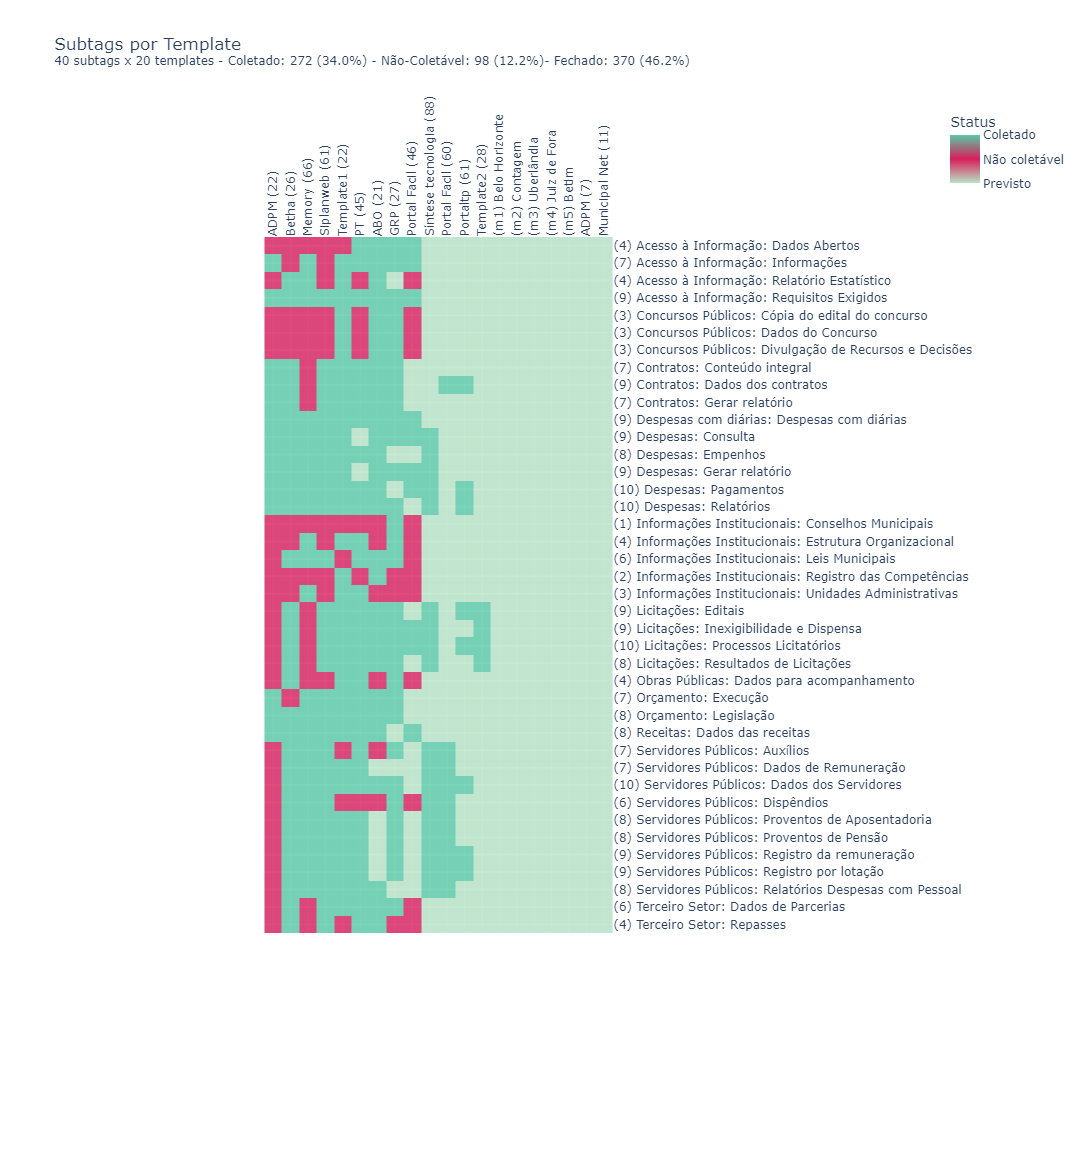

In [8]:
def plot_tags_coletadas(epics):
    
    n_templates_cobertos = epics[epics == 2].count(axis=1).values
    n_subtags_pendentes  = epics[epics == 0].count(axis=0).values

    y = [f'({n}) {tag}' for n, tag in zip(n_templates_cobertos, epics.index)]
    x = [t for n, t in sorted(zip(n_subtags_pendentes, epics.columns))]

    tot_coletado = sum(n_templates_cobertos)
    tot_nao_coletavel = epics[epics == 1].count().sum()
    tot = len(x) * len(y)
    
    title = f'Subtags por Template<br><sup>{len(y)} subtags x {len(x)} templates '
    title += f'- Coletado: {tot_coletado} ({round( tot_coletado*100/tot , 1)}%) '
    title += f'- Não-Coletável: {tot_nao_coletavel} ({round( tot_nao_coletavel*100/tot , 1)}%)'
    title += f'- Fechado: {tot_coletado+tot_nao_coletavel} ({round( (tot_coletado+tot_nao_coletavel)*100/tot , 1)}%)</sup>'
    
    #TODO discrete scale
    fig = px.imshow(
        epics[x], y=y, height=1150, width=800, title=title, 
        color_continuous_scale=[(0, '#B9E3C6'), (0.5, '#D81E5B'), (1, '#59C9A5')])     
        
    fig.update_traces(opacity=0.80)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_yaxes(showgrid=True, gridwidth=2, side='right')
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Status", lenmode='pixels', len=90, x=1.2, y=0.95, 
            tickvals=[0,1,2],
            ticktext=['Previsto', 'Não coletável', 'Coletado']), 
        font=dict(size=12))
    
    fig.write_image('fig/tags.png', scale=3)    
    
    return fig

#TODO change dpi
def process_epics_for_tags(epics, top_templates, subtags):       
    
    templates = top_templates.template.unique()
    epics = epics[epics.template.isin(templates)]
    
    epics = epics[(epics.tag.notnull()) & (epics.template.notnull())] 
        
    s = epics[(epics.subtag.isnull()) | (epics.subtag.str.contains('Todas'))][
        ['template', 'tag', 'state']].copy()
    all_subtags_ok  = s[s.state == 'Coletado']
    all_subtags_nok = s[s.state == 'Não coletável']
    
    epics = epics[(epics.state == 'Coletado') | (epics.state == 'Não coletável')]
    epics = epics[(epics.subtag.notnull()) & (epics.subtag.str.contains('Todas') == False)]
    
    # explode a lista de subtags em multiplas linhas
    epics.subtag = epics.subtag.apply(eval)
    epics = epics.explode('subtag')
    epics['tag_subtag'] = epics['tag'] + ': ' + epics['subtag']
    epics = epics.drop_duplicates(['tag_subtag', 'template']) 

    epics = epics[['tag_subtag', 'template', 'state']]    
    epics.loc[epics.state == 'Coletado', 'state'] = 2    
    epics.loc[epics.state == 'Não coletável', 'state'] = 1          
    
    epics = epics.pivot(index='tag_subtag', columns='template', values='state')
    epics = epics[epics.index.notnull()]
    
    # Adiciona templates e subtags faltantes
    for t in [t for t in templates if t not in epics.columns]: 
        epics[t] = 0
    for s in [s for s in subtags if s not in epics.index]: 
        epics = pd.concat([epics, pd.DataFrame(None, index=[s])])
    
    # Adiciona informacoes de epics que cobrem multiplas subtags
    #TODO despesas com diarias vs. despesas, mesmo prefixo
    for index, row in all_subtags_ok.iterrows():
        epics.loc[epics.index.str.startswith(f'{row["tag"]}:'), row['template']] = 2
    for index,row in all_subtags_nok.iterrows():
        epics.loc[epics.index.str.startswith(f'{row["tag"]}:'), row['template']] = 1
        
    shortnames = {x:y for x,y in zip(top_templates.template.values, top_templates.shortname.values)} 
    epics = epics.rename(columns=shortnames)
    epics = epics.sort_index()
    epics = epics.fillna(0)    
    
    epics.to_csv('data/tags_epics.csv', index_label='subtag')
    
    return epics
       

epics_df = pd.read_csv("data/epics.csv")
top_templates = pd.read_csv("data/top_templates.csv")    
epics_dev = pd.read_csv("data/epics_dev.csv", index_col="template_rank")
subtags = epics_dev.columns.to_list()
# display(epics_df)
# display(top_templates)

tags = process_epics_for_tags(epics_df, top_templates, subtags)
plot_tags_coletadas(tags)
# tags

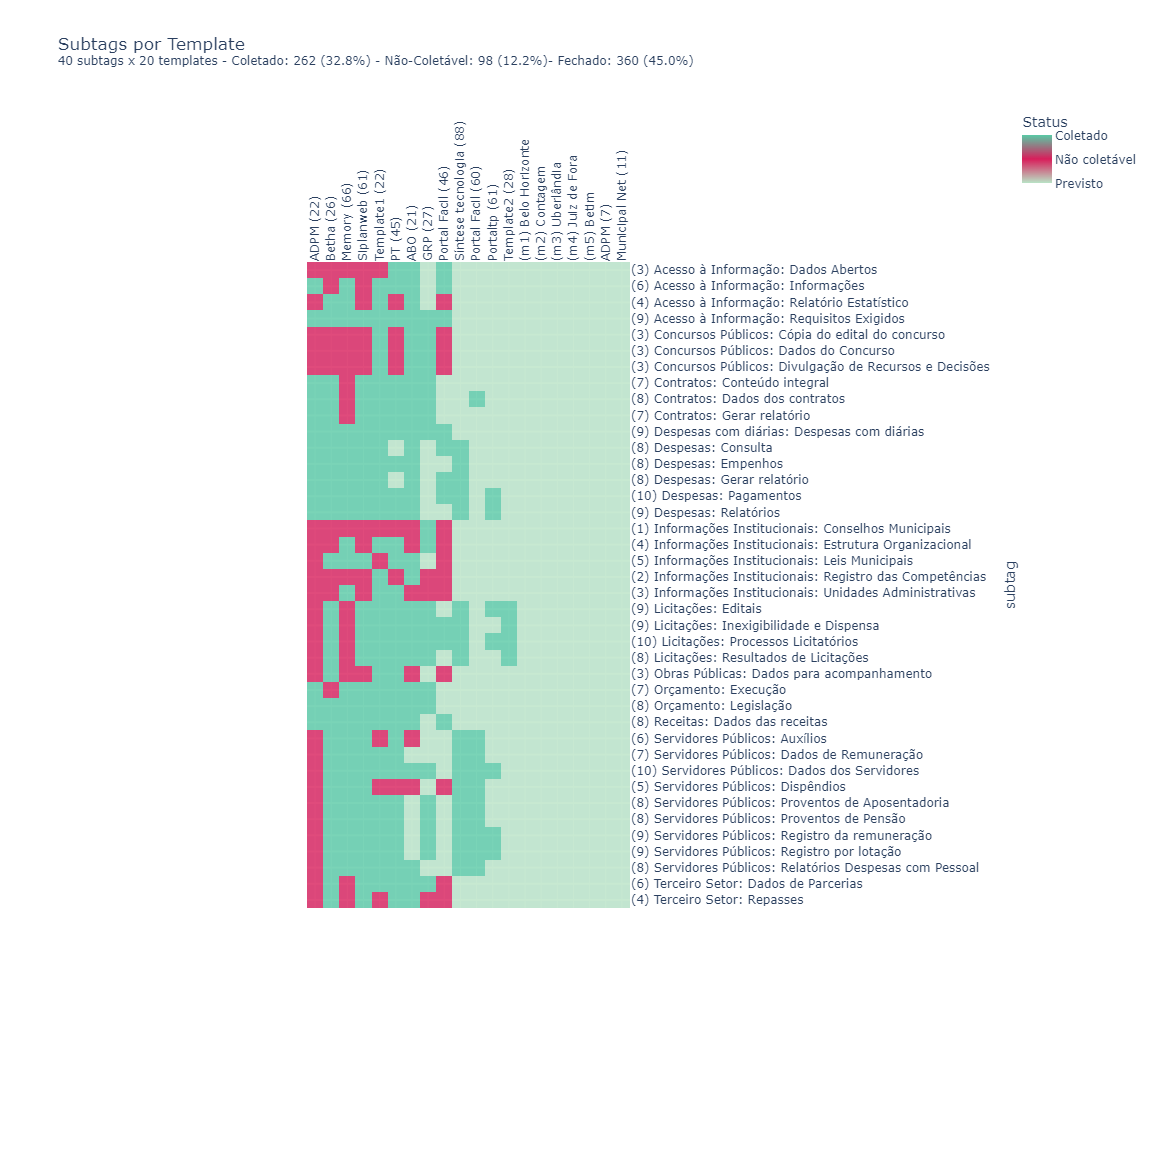

In [24]:
# from file
tags = pd.read_csv('data/tags_epics.csv', index_col='subtag')
plot_tags_coletadas(tags)

In [392]:
epics_df.groupby('state').count()

,title,git_issue,created_at,closed_at,template,tag,subtag,aux
state,,,,,,,,
Coletado,152,152,152,152,152,152,103,152
Com bloqueio,4,4,4,0,4,4,2,4
Com epic criada,33,33,33,0,33,33,15,33
Não coletável,59,59,59,59,59,59,43,59


In [198]:
epics_df[epics_df.template.isnull()]

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
214,Coletor para o template da Portal Fácil (46) (...,95,2021-11-19 10:35:27,2022-11-04 12:11:47,Coletado,NaN,NaN,NaN,1


In [199]:
epics_df[epics_df.tag.isnull()]

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
214,Coletor para o template da Portal Fácil (46) (...,95,2021-11-19 10:35:27,2022-11-04 12:11:47,Coletado,NaN,NaN,NaN,1


In [668]:
# print( epics_df[epics_df.subtag.isnull()][['git_issue', 'template', 'tag', 'state']].sort_values('template').values )
# print( epics_df[epics_df.subtag.isnull()][['git_issue', 'template', 'tag']].sort_values('tag').values )
# epics_df[epics_df.subtag == 'Relatórios']
# tags[tags.index.str.contains('Dados  dos contratos')]

In [205]:
#2249
# epics_df[epics_df.tag.fillna('').str.startswith('Inform')].reset_index(drop=True)
epics_df.query('git_issue == 1963')

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
11,Coletor para o Template1 (22) - Informações In...,1963,2022-10-07 15:10:34,2022-10-07 15:10:46,Não coletável,Template1 (22),Informações Institucionais,Leis Municipais,1


In [586]:
epics_df[epics_df.template.fillna('').str.endswith('(60)')].reset_index(drop=True)

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
0,Coletor para o template da Portal Fácil (60) (...,94,2021-11-19 10:34:34,NaN,Com epic criada,Portal Facil (60),Licitações,NaN,1
1,Coletor para o template Portal Fácil (60) - Se...,2238,2022-10-28 13:10:31,2022-10-31 11:15:14,Coletado,Portal Facil (60),Servidores,NaN,1
2,Coletor para o template Portal Fácil (60) - Co...,2243,2022-10-31 11:21:08,NaN,Com epic criada,Portal Facil (60),Contratos,NaN,1
3,Coletor para o template Portal Fácil (60) - Li...,1959,2022-09-29 12:22:30,NaN,Com epic criada,Portal Facil (60),Licitações,NaN,1


#TODO repassar pra valid
Nos dois: 15

Em tudo mas não visto: 25, ['Acesso à Informação: Bases de dados abertos', 'Acesso à Informação: Relatório estatístico', 'Concursos Públicos: Cópia do edital do concurso', 'Concursos Públicos: Dados do Concurso', 'Concursos Públicos: Divulgação', 'Contratos: Conteúdo integral', 'Contratos: Dados dos contratos', 'Contratos: Gerar relatório', 'Despesas: Consulta', 'Informações institucionais: Conselhos Municipais', 'Informações institucionais: Estrutura organizacional', 'Informações institucionais: Link de acesso', 'Informações institucionais: Registro das competências', 'Informações institucionais: Unidades administrativas', 'Licitações: Editais', 'Licitações: Processos licitatórios', 'Licitações: Registro dos procedimentos', 'Licitações: Resultados das licitações', 'Obras públicas: Dados para acompanhamento', 'Servidores Públicos: Auxilios', 'Servidores Públicos: Dados de remuneração', 'Servidores Públicos: Dados dos servidores', 'Servidores Públicos: Proventos de aposentadoria', 'Servidores Públicos: Proventos de pensão', 'Servidores Públicos: Relatório mensal']

Visto mas não em tudo: 12, ['Acesso à Informação: Dados Abertos', 'Acesso à Informação: Relatório Estatístico', 'Informações Institucionais: Conselhos Municipais', 'Informações Institucionais: Estrutura Organizacional', 'Informações Institucionais: Leis Municipais', 'Informações Institucionais: Registro das Competências', 'Informações Institucionais: Unidades Administrativas', 'Licitações: Inexigibilidade e Dispensa', 'Licitações: Processos Licitatórios', 'Servidores Públicos: Auxílios', 'Servidores Públicos: Dados de Remuneração', 'Servidores Públicos: Relatórios Despesas com Pessoal']
 ['Contratos: Dados  dos contratos', 'Servidores Públicos: Dados dos Servidores', 'Servidores Públicos: Proventos de Aposentadoria', 'Servidores Públicos: Proventos de Pensão']

In [303]:
import re 
def find_label(item_labels, target_label):    
    
    item_labels = str(item_labels)
    found = re.match(r'.*"' + target_label + r' - ([^"]*?)"', item_labels)    
    
    if found: 
        return found.group(1)
    
    return None

def find_label2(item_labels, target_label):    
    
    item_labels = str(item_labels)
    
    if target_label == 'subtag':
        found = re.findall(r'"subtag - ([^"]*?)"', item_labels)    
        if found: return found
        else: return None
    
    found = re.match(r'.*"' + target_label + r' - ([^"]*?)"', item_labels)    
    if found: 
        return found.group(1)
    
    return None

# l = load_labels(repo_F01, 1963)
for epic_id in [1963, 2103, 515]:
    l = repo_F01.get_issue(epic_id).labels
    print(l,'\n')

    for target in ['template', 'tag', 'subtag']:
        print( f'{target} --> {find_label(l, target)}' )

    print('\nNew Version:')
    for target in ['template', 'tag', 'subtag']:
        print( f'{target} --> {find_label2(l, target)}' )
        
    print('=======================')

[Label(name="Realização F01"), Label(name="Epic"), Label(name="template - Template1 (22)"), Label(name="tag - Informações Institucionais"), Label(name="não-localizado"), Label(name="subtag - Conselhos Municipais"), Label(name="subtag - Leis Municipais")] 

template --> Template1 (22)
tag --> Informações Institucionais
subtag --> ['Conselhos Municipais', 'Leis Municipais']

New Version:
template --> Template1 (22)
tag --> Informações Institucionais
subtag --> ['Conselhos Municipais', 'Leis Municipais']
[Label(name="Realização F01"), Label(name="Epic"), Label(name="tag - Licitações"), Label(name="template - Portal Facil (46)"), Label(name="subtag - Processos Licitatórios")] 

template --> Portal Facil (46)
tag --> Licitações
subtag --> ['Processos Licitatórios']

New Version:
template --> Portal Facil (46)
tag --> Licitações
subtag --> ['Processos Licitatórios']
[Label(name="Realização F01"), Label(name="Epic"), Label(name="template - Síntese tecnologia e informatica (88)"), Label(name="

In [403]:
epics_dev = pd.read_csv("data/epics_dev.csv", index_col="template_rank")
tudo = epics_dev.columns.to_list()
visto = tags.index.to_list()

a = [x for x in tudo if x not in visto]
b = [x for x in visto if x not in tudo]

print(f'Nos dois: { len( [x for x in tudo if x in visto] )}\n')
print(f'Em tudo mas não visto: {len(a)}, {a}\n')
print(f'Visto mas não em tudo: {len(b)}, {b}\n')

Nos dois: 40

Em tudo mas não visto: 0, []

Visto mas não em tudo: 0, []



In [374]:
e = epics_df.copy()
e.subtag = e.subtag.fillna('[]')
e.subtag = e.subtag.apply(eval)
e['n'] = e.subtag.apply(len)
e = e.query('n > 1')

print('before:', e.shape)
display(e.head())

e = e.explode('subtag')
print('after:', e.shape)
e.head()

before: (17, 10)


,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux,n
6,Coletor para o template ABO - Despesas - Empen...,1329,2022-07-25 17:39:43,2022-08-30 10:37:40,Coletado,ABO (21),Despesas,"[Empenhos, Pagamentos]",1,2
7,Coletor para o Template1 (22) - Informações In...,1961,2022-10-05 12:30:10,2022-10-07 15:04:36,Coletado,Template1 (22),Informações Institucionais,"[Estrutura Organizacional, Registro das Compet...",1,3
11,Coletor para o Template1 (22) - Informações In...,1963,2022-10-07 15:10:34,2022-10-07 15:10:46,Não coletável,Template1 (22),Informações Institucionais,"[Conselhos Municipais, Leis Municipais]",1,2
13,Coletor para o template Portaltp - Servidores ...,1964,2022-10-07 19:19:50,2022-10-07 21:17:55,Coletado,Portaltp (61),Servidores Públicos,"[Dados dos Servidores, Registro da remuneração]",1,2
70,Coletor para o template Betha - Servidores Púb...,892,2022-05-27 15:00:48,2022-08-12 19:47:07,Coletado,Betha (26),Servidores Públicos,"[Relatórios Despesas com Pessoal, Dados de Rem...",1,2


after: (47, 10)


,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux,n
6,Coletor para o template ABO - Despesas - Empen...,1329,2022-07-25 17:39:43,2022-08-30 10:37:40,Coletado,ABO (21),Despesas,Empenhos,1,2
6,Coletor para o template ABO - Despesas - Empen...,1329,2022-07-25 17:39:43,2022-08-30 10:37:40,Coletado,ABO (21),Despesas,Pagamentos,1,2
7,Coletor para o Template1 (22) - Informações In...,1961,2022-10-05 12:30:10,2022-10-07 15:04:36,Coletado,Template1 (22),Informações Institucionais,Estrutura Organizacional,1,3
7,Coletor para o Template1 (22) - Informações In...,1961,2022-10-05 12:30:10,2022-10-07 15:04:36,Coletado,Template1 (22),Informações Institucionais,Registro das Competências,1,3
7,Coletor para o Template1 (22) - Informações In...,1961,2022-10-05 12:30:10,2022-10-07 15:04:36,Coletado,Template1 (22),Informações Institucionais,Unidades Administrativas,1,3


In [381]:
e = epics_df.copy()
print(e.shape)
e.subtag = e.subtag.fillna('[]') 
e.subtag = e.subtag.apply(eval)
e['n_subtags'] = e.subtag.apply(len)
r = e.query('n_subtags > 1')[['git_issue', 'template', 'state', 'tag', 'subtag']].sort_values('tag').values

for i in r:
    print(f'{i[:4]}:\n  {i[4:]}\n')

(248, 9)
[2249 'Portal Facil (46)' 'Com epic criada' 'Contratos']:
  [list(['Gerar relatório', 'Dados  dos contratos', 'Conteúdo Integral'])]

[1329 'ABO (21)' 'Coletado' 'Despesas']:
  [list(['Empenhos', 'Pagamentos'])]

[2242 'Portal Facil (46)' 'Coletado' 'Despesas']:
  [list(['Pagamentos', 'Consulta', 'Gerar relatório'])]

[1932 'PT (45)' 'Com epic criada' 'Despesas']:
  [list(['Empenhos', 'Pagamentos'])]

[1778 'PT (45)' 'Com epic criada' 'Despesas']:
  [list(['Empenhos', 'Pagamentos'])]

[1860 'Template1 (22)' 'Coletado' 'Despesas']:
  [list(['Empenhos', 'Pagamentos', 'Consulta', 'Gerar relatório'])]

[192 'Portaltp (61)' 'Com epic criada' 'Despesas']:
  [list(['Empenhos', 'Consulta', 'Gerar relatório'])]

[1963 'Template1 (22)' 'Não coletável' 'Informações Institucionais']:
  [list(['Conselhos Municipais', 'Leis Municipais'])]

[1961 'Template1 (22)' 'Coletado' 'Informações Institucionais']:
  [list(['Estrutura Organizacional', 'Registro das Competências', 'Unidades Administrati

In [7]:
def generateDiscreteColourScale(colour_set):
    #colour set is a list of lists
    colour_output = []
    num_colours = len(colour_set)
    divisions = 1./num_colours
    c_index = 0.
    # Loop over the colour set
    for cset in colour_set:
        num_subs = len(cset)
        sub_divisions = divisions/num_subs
        # Loop over the sub colours in this set
        for subcset in cset:
            colour_output.append((c_index,subcset))
            colour_output.append((c_index + sub_divisions-
                .001,subcset))
            c_index = c_index + sub_divisions
    colour_output[-1]=(1,colour_output[-1][1])
    return colour_output

import matplotlib.colors as mcolors
# l = list(mcolors.BASE_COLORS.values())
l = [(0, '#B9E3C6'), (0.5, '#D81E5B'), (1, '#59C9A5')]
generateDiscreteColourScale(l)

[(0.0, 0),
 (0.16566666666666666, 0),
 (0.16666666666666666, '#B9E3C6'),
 (0.3323333333333333, '#B9E3C6'),
 (0.3333333333333333, 0.5),
 (0.499, 0.5),
 (0.5, '#D81E5B'),
 (0.6656666666666666, '#D81E5B'),
 (0.6666666666666666, 1),
 (0.8323333333333333, 1),
 (0.8333333333333333, '#59C9A5'),
 (1, '#59C9A5')]

In [ ]:

# color_continuous_scale=[(0, '#b5dbe8'), (0.5, '#FF2E2E'), (1, '#00A300')]
# (0.25, 'lightgreen'), (0.5, "#64b5cd"), (0.75, '#FFD700'), (1, 'lightblue')]

# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
# https://morioh.com/p/c697dda8f5a1
#Titan theme
#0e58c6	(14,88,198) cool blue
#ffe042	(255,224,66) yellow
#d60000	(214,0,0) red
#5851db	(88,81,219) blue
#4e4e4e	(78,78,78) grey

#     # Plot
#     fig = px.bar(
#         df, y=count_col, x=name_col, color='state', height=800, width=1100, title=title,
#         color_discrete_map = {
#             'Coletado':'green', 
#             'Coletado (autom.)':'#92d696', 
#             'Com bloqueio':'#9F2B68',
#             'Com epic criada':'#64b5cd', 
#             'Estimado':'lightblue', 
#             'Não coletável':'red', 
#             'Não coletável (autom.)':'#ff9e99'}, 
#         labels = {
#             count_col:"#Coletores", 
#             name_col:"Template / Município"}, 
#         opacity = 0.75 )    
    
#     fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':xorder})
#     fig.update_xaxes(tickangle=45)
#     fig.update_layout(font=dict(size=18))    

## Dashboard de Validação

In [ ]:
exigencias_df = pd.read_csv("data/exigencias_dev.csv", usecols=["tag","subtag"]).drop_duplicates()
exigencias_df

In [ ]:
epics_dev_df = pd.read_csv("data/tmp.csv").drop(columns=['title', 'tag', 'subtag']).drop_duplicates(
    'template', ignore_index=True).dropna(subset=['template'])

epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.pivot(index="template", columns="title", values="state")

epics_dev_df[:] = 3

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

In [ ]:
epics_dev_df = pd.read_csv("data/top_templates.csv")

epics_dev_df = epics_dev_df[epics_dev_df['rank'] <= 15]
epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.drop(columns=['tag', 'subtag'])

y_label = "template_rank"
epics_dev_df[y_label] = epics_dev_df["template"] + " (" + epics_dev_df["rank"].astype(str) + "º)"
epics_dev_df = epics_dev_df.drop(columns=["template"])

epics_dev_df = epics_dev_df.pivot(index="template_rank", columns="title", values="rank")
epics_dev_df[:] = 4

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

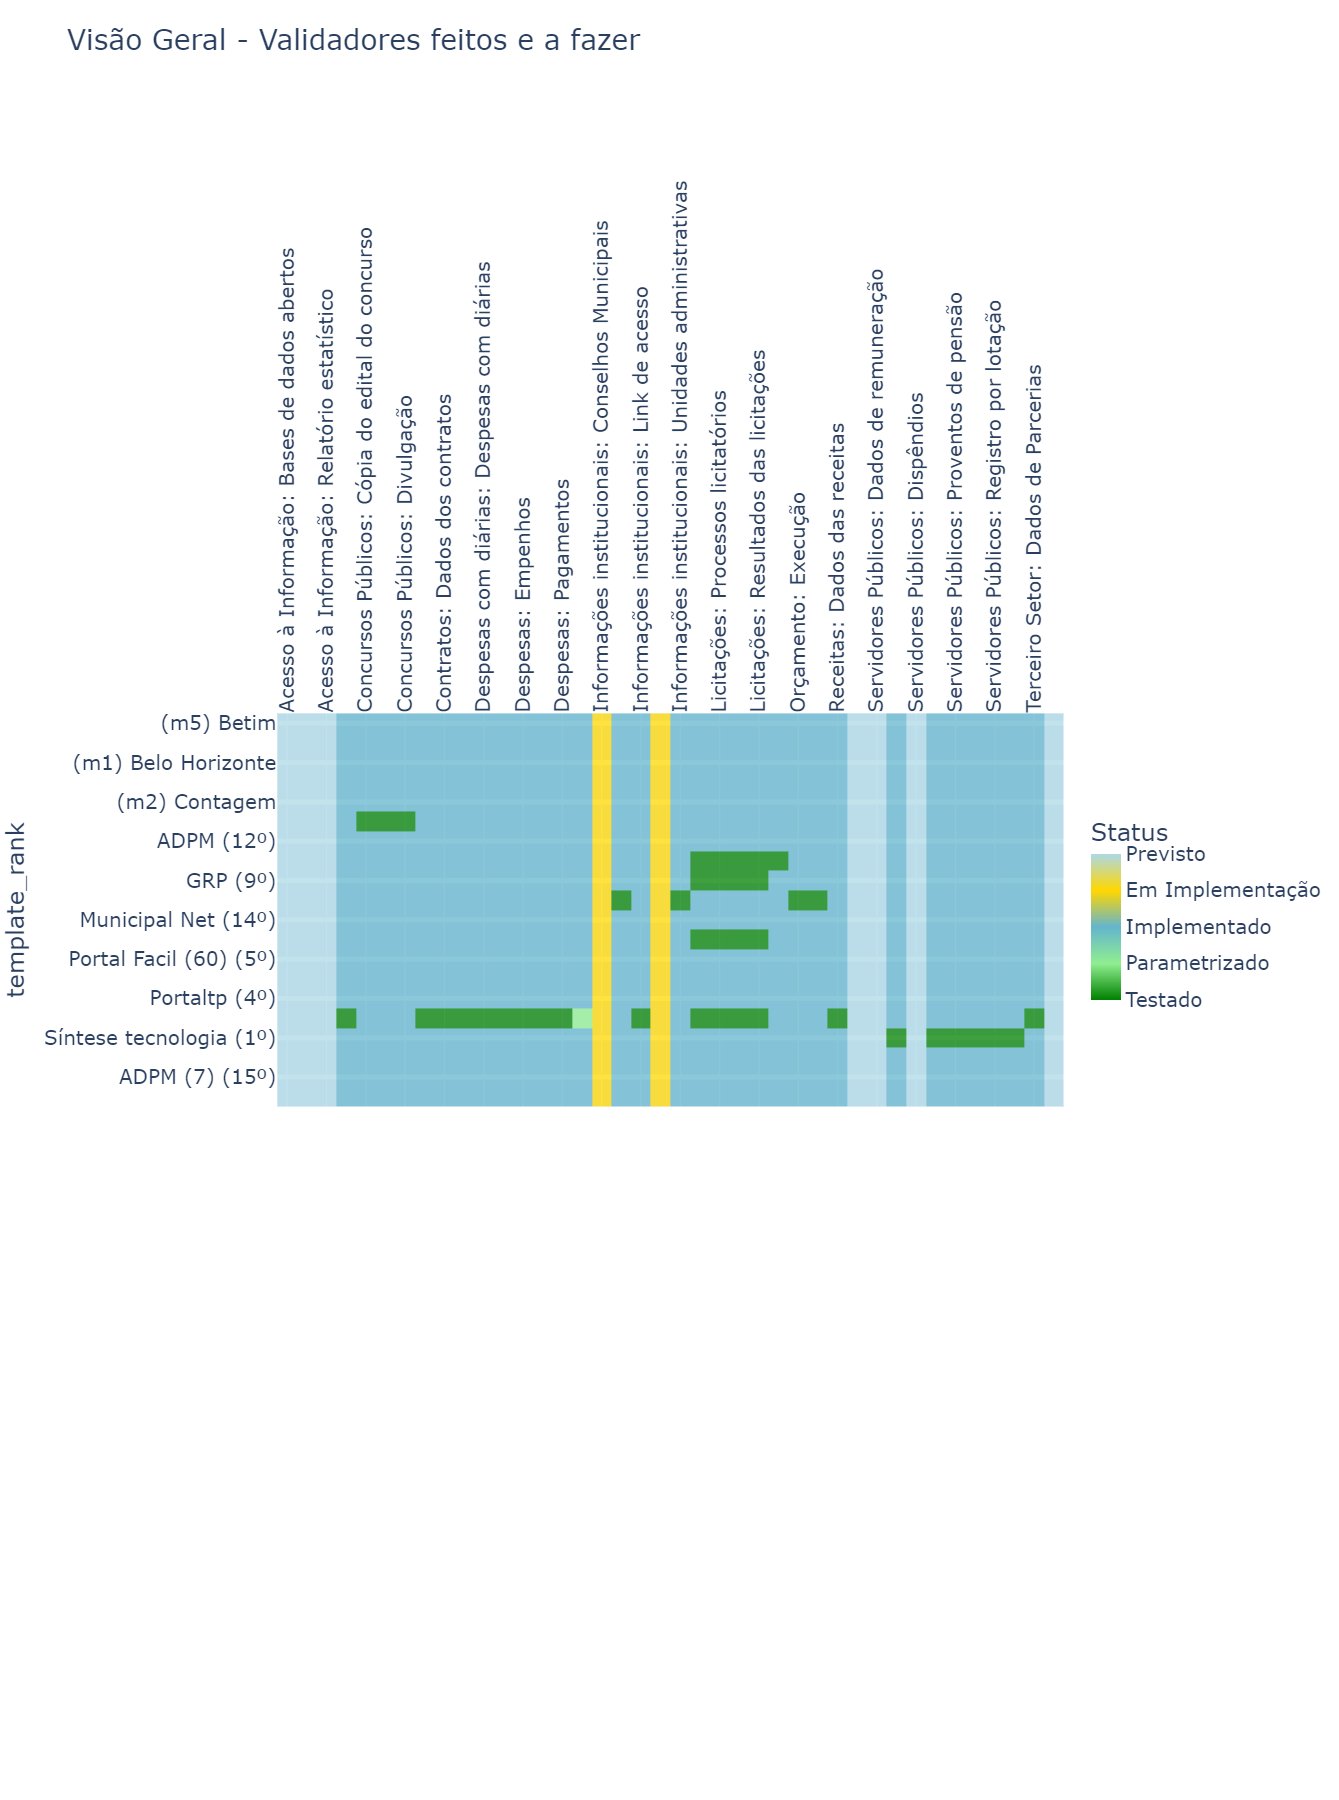

In [428]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_status_epics_dev(df, title, y_column, x_column, hue, showlegend=True):    

    fig = px.imshow(
        df, height=1800, width=1700, title=title,
        color_continuous_scale=[(0, "green"), (0.25, 'lightgreen'), (0.5, "#64b5cd"), 
                                (0.75, '#FFD700'), (1, 'lightblue')]
    )     
        
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_yaxes(showgrid=True, gridwidth=5)
    
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Status", 
            tickvals=[1,2,3,4,5],
            ticktext=["Testado","Parametrizado","Implementado","Em Implementação",'Previsto'],
            lenmode="pixels", 
            len=200), 
        font=dict(size=20)
    )
    
    return fig

#-----------------------------------------------------------------------

figures.plot_status_epics_dev = plot_status_epics_dev

epics_dev_df = pd.read_csv("data/epics_dev.csv", index_col="template_rank")

fig = figures.plot_status_epics_dev(epics_dev_df, title='Visão Geral - Validadores feitos e a fazer',        
        y_column='template', x_column='title', hue="state", showlegend=True)


fig.write_image('./fig/status-dev.png')#, scale=1)
fig